# H1B Visa Classifier

### How to Execute

- Download the data set from [h1b-case-status-prediction](https://www.kaggle.com/abishekanbarasan1995/h1b-case-status-prediction) and place it under data folder
- Extract the zip files and place them under data folder

In [1]:
# import all the python libraries required
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plot
import warnings; warnings.simplefilter('ignore')

from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC

from imblearn.over_sampling import ADASYN

In [2]:
# Load 2015 Visa Data
data2015 = pd.read_csv("data/H-1B_Disclosure_RAW_Data_FY15.csv", encoding='latin-1', low_memory=False)
data2015.rename(columns = {'H-1B_DEPENDENT':'H1B_DEPENDENT'}, inplace = True)

In [3]:
# Load 2016 Visa Data
data2016 = pd.read_csv("data/H-1B_Disclosure_RAW_Data_FY16.csv", encoding='latin-1', low_memory=False)
data2016.rename(columns = {'H-1B_DEPENDENT':'H1B_DEPENDENT'}, inplace = True)

In [4]:
# Load 2017 Visa Data
data2017 = pd.read_csv("data/H-1B_Disclosure_RAW_Data_FY17.csv", encoding='latin-1', low_memory=False)

In [5]:
# Load 2018 Visa Data
data2018 = pd.read_csv("data/H-1B_Disclosure_RAW_Data_FY18.csv", encoding='latin-1', low_memory=False)

In [6]:
# merger all the data frames into one
data = pd.concat([
    data2015,
    data2016,
    data2017,
    data2018
])
# data = pd.read_csv("data/_test.csv", encoding='latin-1', low_memory=False)

C:\Users\psahu\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


## Data Pre-Processing

In [7]:
#select features which are relevant for the classification
data = data[['CASE_NUMBER','CASE_STATUS','VISA_CLASS','EMPLOYER_NAME','EMPLOYER_CITY','EMPLOYER_STATE','SOC_NAME','WAGE_RATE_OF_PAY_FROM','WAGE_UNIT_OF_PAY','H1B_DEPENDENT']]
data.rename(columns = {'WAGE_RATE_OF_PAY_FROM':'WAGE_RATE'}, inplace = True)

print(data.shape)

(2545666, 10)


In [8]:
# Drop all rows with null values
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
print(data.shape)

(1885498, 10)


In [9]:
#Drop all visa entry other than H1B type
data.drop(data[(data.VISA_CLASS != 'H-1B')].index,axis=0, inplace=True)
data['VISA_CLASS'].value_counts()

H-1B    1883551
Name: VISA_CLASS, dtype: int64

CERTIFIED              1658526
CERTIFIED-WITHDRAWN     139307
WITHDRAWN                62542
DENIED                   23176
Name: CASE_STATUS, dtype: int64


[Text(0, 0, 'CERTIFIED'),
 Text(0, 0, 'CERTIFIED-WITHDRAWN'),
 Text(0, 0, 'WITHDRAWN'),
 Text(0, 0, 'DENIED')]

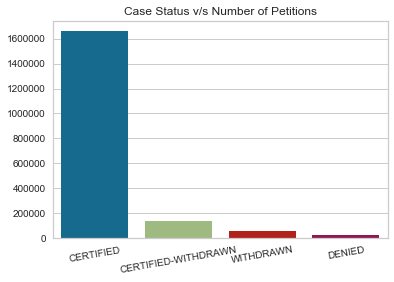

In [10]:
print(data['CASE_STATUS'].value_counts())
caseStatus = data['CASE_STATUS'].value_counts()[:6]
bxPlt = sb.barplot(x = caseStatus.index, y = caseStatus.values)
bxPlt.set_title('Case Status v/s Number of Petitions')
bxPlt.set_xticklabels(bxPlt.get_xticklabels(),rotation=10)

In [11]:
#convert wage to Float
data['WAGE_RATE'] = data['WAGE_RATE'].str.split('.').str[0].str.replace(',','').astype(float)

#convert all wages to yearly
# df.loc[df.First_name == 'Bill', 'name_match'] = 'Match'
data.loc[data.WAGE_UNIT_OF_PAY == 'Hour', 'WAGE_RATE'] = data['WAGE_RATE'] * 8 * 5 * 52
data.loc[data.WAGE_UNIT_OF_PAY == 'Month', 'WAGE_RATE'] = data['WAGE_RATE'] * 12
data.loc[data.WAGE_UNIT_OF_PAY == 'Week', 'WAGE_RATE'] = data['WAGE_RATE'] * 52
data.loc[data.WAGE_UNIT_OF_PAY == 'Bi-Weekly', 'WAGE_RATE'] = data['WAGE_RATE'] * 26

data['WAGE_UNIT_OF_PAY'].value_counts()

Year         1764821
Hour          116628
Month           1303
Week             520
Bi-Weekly        279
Name: WAGE_UNIT_OF_PAY, dtype: int64

count    1.883551e+06
mean     1.040974e+05
std      1.932916e+06
min      0.000000e+00
25%      6.500000e+04
50%      8.000000e+04
75%      1.005680e+05
max      1.000000e+09
Name: WAGE_RATE, dtype: float64


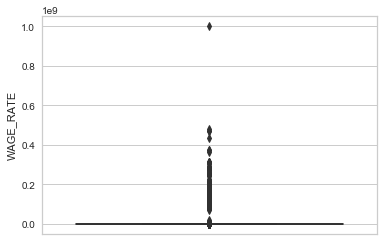

In [12]:
# Show Wages plot
print(data['WAGE_RATE'].describe())
sb.boxplot(y=data['WAGE_RATE'])
plot.show()

#### Removing outliers from WATE_RATE

count    1.780308e+06
mean     8.254697e+04
std      2.362758e+04
min      2.784000e+04
25%      6.500000e+04
50%      7.800000e+04
75%      9.636600e+04
max      1.499990e+05
Name: WAGE_RATE, dtype: float64


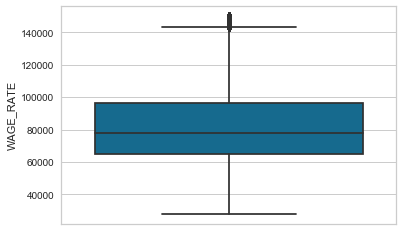

In [13]:
# Remove the outliers.
lowerBound = 0.001
upperBound = 0.95
result = data.WAGE_RATE.quantile([lowerBound, upperBound])
true_index = (result.loc[lowerBound] < data.WAGE_RATE.values) & \
             (data.WAGE_RATE.values < result.loc[upperBound])

data = data[(result.loc[lowerBound] < data.WAGE_RATE.values) & (data.WAGE_RATE.values < result.loc[upperBound])]
# data.reset_index(drop=True,inplace=True)

print(data['WAGE_RATE'].describe())
sb.boxplot(y=data['WAGE_RATE'])
plot.show()


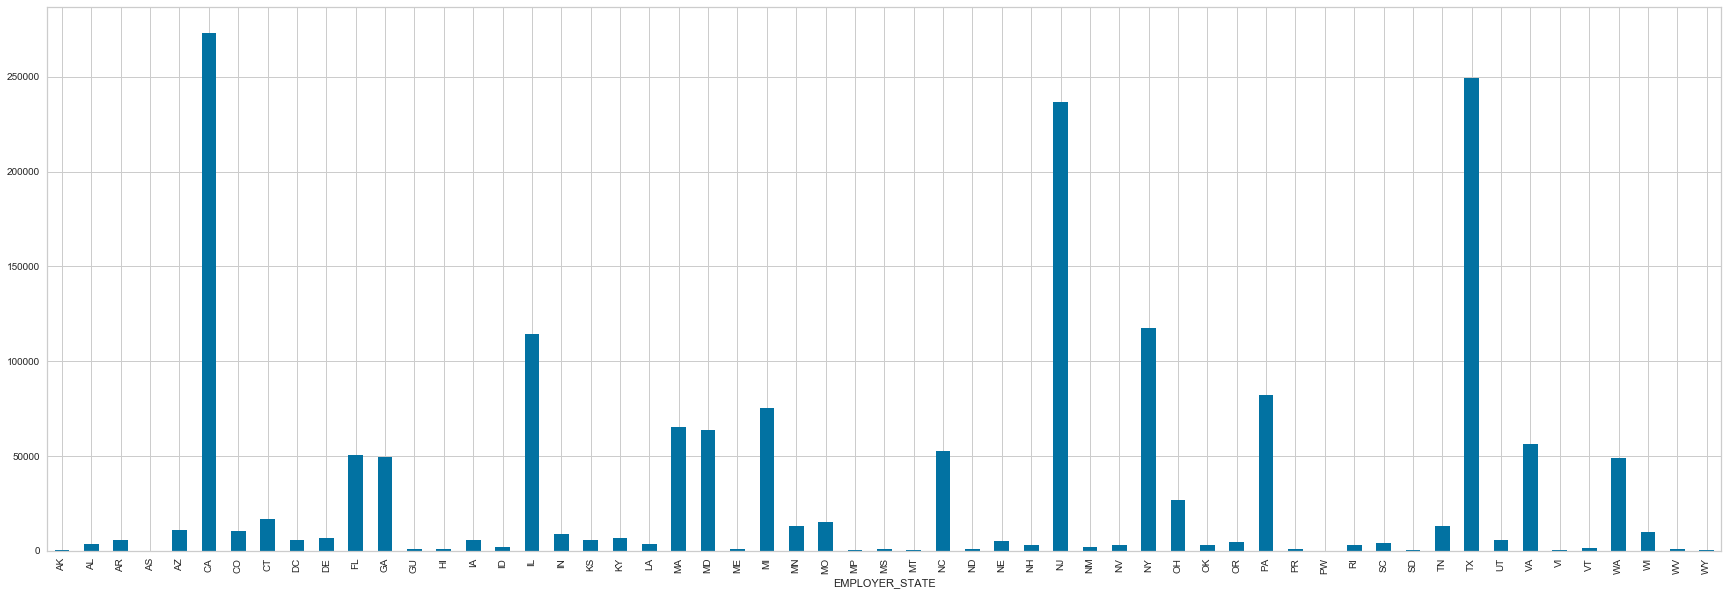

(1780308, 8)


In [14]:
# Plot the state wise distribution of visa application
data.groupby('EMPLOYER_STATE')['CASE_NUMBER'].nunique().plot(kind='bar', figsize=(30,10))
plot.show()

data = data[['CASE_STATUS','VISA_CLASS','EMPLOYER_NAME','EMPLOYER_CITY','EMPLOYER_STATE','SOC_NAME','WAGE_RATE','H1B_DEPENDENT']]
print(data.shape)

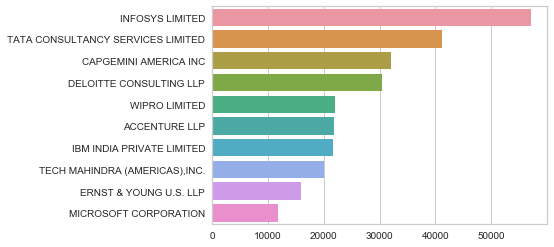

In [15]:
# Get all distinct EMPLOYERS
employer = data['EMPLOYER_NAME'].value_counts()[:10]
sb.barplot(x = employer.values, y = employer.index)

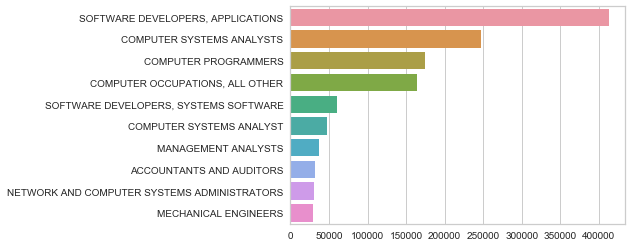

In [16]:
# Different Job titles
jobCategory = data['SOC_NAME'].value_counts()[:10]
sb.barplot(x = jobCategory.values, y = jobCategory.index)

In [17]:
# Data Transformation
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# print(data)
for column_name in data.columns:
    if data[column_name].dtype == object:
        data[column_name] = le.fit_transform(data[column_name])
    else:
        pass

In [18]:
X = data.drop('CASE_STATUS', axis=1)
y = data['CASE_STATUS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y)

In [19]:
y_train.value_counts()

0    1097426
1      92461
3      41348
2      14980
Name: CASE_STATUS, dtype: int64

In [20]:
ada = ADASYN(sampling_strategy='not majority',random_state=42)
X_train, y_train = ada.fit_sample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train))

Resampled dataset shape Counter({3: 1104238, 0: 1097426, 2: 1096480, 1: 1078429})


## KNeighbour Classifier

In [21]:
# KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, weights = 'uniform')
knn.fit(X_train, y_train)
knn_prediction = knn.predict(X_test)

### KNN Evaluation

              precision    recall  f1-score   support

           0       0.93      0.67      0.78    470326
           1       0.20      0.50      0.29     39626
           2       0.04      0.24      0.07      6420
           3       0.09      0.29      0.13     17721

    accuracy                           0.64    534093
   macro avg       0.32      0.43      0.32    534093
weighted avg       0.83      0.64      0.71    534093



C:\Users\psahu\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


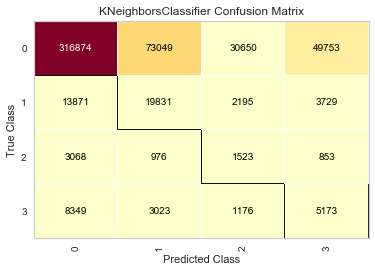

C:\Users\psahu\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


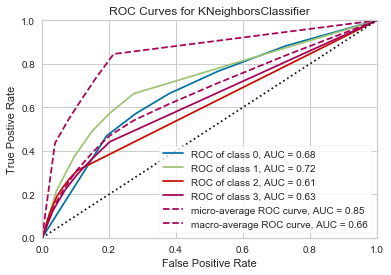

In [22]:
# Evaluation
print(metrics.classification_report(y_test, knn_prediction))

classes = unique_labels(y_test, knn_prediction)
confusion_matrix = ConfusionMatrix(knn, classes= classes, 
                     label_encoder={0: 'CERTIFIED', 1: 'CERTIFIED-WITHDRAWN', 2: 'WITHDRAWN', 3: 'DENIED'})

confusion_matrix.score(X_test, y_test)
confusion_matrix.show()

# Initializing the visualizer with the classification
visualizer = ROCAUC(knn, classes=classes)

# visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
auc_score = visualizer.score(X_test, y_test)
visualizer.show()

## Decision Tree Classification

In [23]:
# Decision Tree Classifier
decisionTreeClassifier = DecisionTreeClassifier()
decisionTreeClassifier.fit(X_train, y_train)

dtc_predict = decisionTreeClassifier.predict(X_test)

### Decision Tree Classification Evaluation

              precision    recall  f1-score   support

           0       0.91      0.84      0.88    470326
           1       0.27      0.41      0.33     39626
           2       0.07      0.13      0.09      6420
           3       0.13      0.22      0.16     17721

    accuracy                           0.78    534093
   macro avg       0.35      0.40      0.37    534093
weighted avg       0.83      0.78      0.80    534093



C:\Users\psahu\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


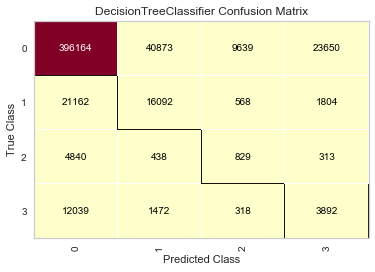

C:\Users\psahu\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


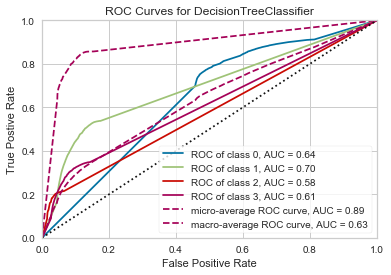

In [24]:
# Evaluation
print(metrics.classification_report(y_test, dtc_predict))

classes = unique_labels(y_test, dtc_predict)
confusion_matrix = ConfusionMatrix(decisionTreeClassifier, classes= classes, 
                     label_encoder={0: 'CERTIFIED', 1: 'CERTIFIED-WITHDRAWN', 2: 'WITHDRAWN', 3: 'DENIED'})

confusion_matrix.score(X_test, y_test)
confusion_matrix.show()

# Initializing the visualizer with the classification
visualizer = ROCAUC(decisionTreeClassifier, classes=classes)

# visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
auc_score = visualizer.score(X_test, y_test)
visualizer.show()

## Random Forest Classification

In [25]:
# Random Forest
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
rfc_prediction = random_forest.predict(X_test)
# rfc_prediction

metrics.accuracy_score(y_test, rfc_prediction)

C:\Users\psahu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.802317199439049

### Random Forest Classfication Evaluation

              precision    recall  f1-score   support

           0       0.91      0.87      0.89    470326
           1       0.30      0.41      0.35     39626
           2       0.10      0.14      0.11      6420
           3       0.16      0.22      0.18     17721

    accuracy                           0.80    534093
   macro avg       0.37      0.41      0.38    534093
weighted avg       0.83      0.80      0.82    534093



C:\Users\psahu\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


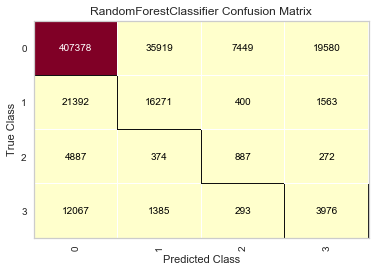

C:\Users\psahu\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


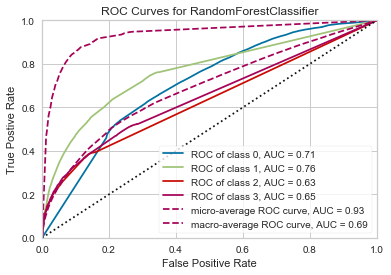

In [26]:
# Evaluation
print(metrics.classification_report(y_test, rfc_prediction))

classes = unique_labels(y_test, rfc_prediction)
confusion_matrix = ConfusionMatrix(random_forest, classes= classes, 
                     label_encoder={0: 'CERTIFIED', 1: 'CERTIFIED-WITHDRAWN', 2: 'WITHDRAWN', 3: 'DENIED'})

confusion_matrix.score(X_test, y_test)
confusion_matrix.show()

# Initializing the visualizer with the classification
visualizer = ROCAUC(random_forest, classes=classes)

# visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
auc_score = visualizer.score(X_test, y_test)
visualizer.show()